[https://cvml.tistory.com/8]

[https://pytorch.org/docs/master/notes/amp_examples.html]

[https://github.com/NVIDIA/apex]

을 참고해서 작성하였다.

Mixed Precison이란, 처리 속도를 높이기 위한 FP16(16bit floating point)연산과 정확도 유지를 위한 FP32 연산을 섞어 학습하는 방법이다.

FP32로 연산 처리를 하는 것이 기본인데, 일정 부분만을 더 낮은 범주의 FP16으로 처리함으로써 속도를 향상 시킬 수 있다.


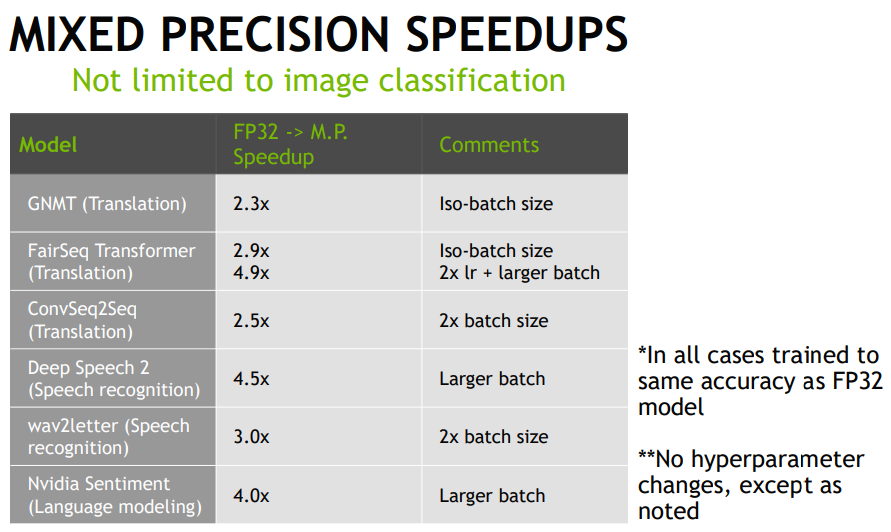


Model에 따라서 성능향상의 차이가 존재한다.

- loss 계산해주고, optimizer에 zero_grad 걸어준 다음
- amp.scale_loss로 감싸서 backward 진행
- optimizer step 진행

In [ ]:
# Declare model and optimizer as usual, with default (FP32) precision
model = torch.nn.Linear(D_in, D_out).cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

# Allow Amp to perform casts as required by the opt_level
model, optimizer = amp.initialize(model, optimizer, opt_level="O1")
...
# loss.backward() becomes:
with amp.scale_loss(loss, optimizer) as scaled_loss:
    scaled_loss.backward()
...

In [ ]:
def train(self, mode, dataloader, epoch_index=0):
        start_timestamp = time()
        self.model.train() if mode == 'train' else self.model.eval() 
        scaler = torch.cuda.amp.GradScaler()
        
        for batch_index, (x,y) in enumerate(tqdm(dataloader)):
            self.optimizer.zero_grad()
            x,y = x.to(self.device, dtype=torch.float), y.to(self.device, dtype=torch.long)
            
            if mode == 'train':
                # cutmix
                lam = np.random.beta(1.0, 1.0)
                rand_index = torch.randperm(x.size()[0])
                shuffled_labels = y[rand_index]
                bbx1, bby1, bbx2, bby2 = cut(x.shape[2], x.shape[3], lam) # define a box to cut and mix
                x[:, :, bbx1:bbx2, bby1:bby2] = x[rand_index, :, bbx1:bbx2, bby1:bby2] #cut and mix
                lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x.shape[-1] * x.shape[-2]))
                with torch.cuda.amp.autocast():
                    y_pred = self.model(x)
                    loss = self.loss(y_pred, y) * lam + self.loss(y_pred, shuffled_labels)*(1.0-lam)
                self.scaler.scale(loss).backward()
                self.scaler.step(self.optimizer)
                self.scaler.update()

                # loss = self.loss(y_pred, y)             
                # loss = F.cross_entropy(y_pred, y1).item() * lamb + F.cross_entropy(y_pred, y2).item() * (1.0-lamb)  
            else:
                # Inference                
                y_pred = self.model(x) 
                loss = self.loss(y_pred, y)             
            
            # Update
            if mode == 'train':
                
                loss.backward()

                with torch.cuda.amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward() 
                 
                    
                self.optimizer.step()
                self.scheduler.step()

            elif mode in ['val','test']:
                pass
            else:
                raise ValueError('Mode should be either train, val, or test')
            
            # History
            #self.filenames += filename
            self.loss_sum += loss.item()
            self.y_preds.append(y_pred.argmax(dim=1))
            self.y.append(y)  
            
        # Epoch history
        self.loss_mean = self.loss_sum / len(dataloader)
        
        # Metric
        self.y_preds = torch.cat(self.y_preds, dim=0).cpu().tolist()
        self.y = torch.cat(self.y, dim=0).cpu().tolist()
        
        for metric_name, metric_func in self.metrics.items():
            score = metric_func(self.y, self.y_preds)
            self.score_dict[metric_name] = score
        
        # Elapsed time
        end_timestamp = time()
        self.elapsed_time = end_timestamp - start_timestamp
        
        
        
        
       